### Курсовой проект "Real Estate Price Prediction" для курса Geekbrains "Python для Data Science".

#### Тема проекта: «Предсказание цен на квартиры»

#### Задание для курсового проекта Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [43]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
matplotlib.rcParams.update({'font.size': 12})



In [44]:
def reduce_mem_usage(df):
    """ 
    Функция меньшения объема памяти, который занимает датасет      
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных в DataFrame
Описание файлов
train.csv - тренировочные данные
test.csv - тестовые данные

Описание признаков данных:

•	Id - идентификационный номер квартиры

•	DistrictId - идентификационный номер района

•	Rooms - количество комнат

•	Square - площадь

•	LifeSquare - жилая площадь

•	KitchenSquare - площадь кухни

•	Floor - этаж

•	HouseFloor - количество этажей в доме

•	HouseYear - год постройки дома

•	Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

•	Social_1, Social_2, Social_3 - социальные показатели местности, возможно - количество рабочих мест, либо как далеко до садика, до школы, до университета, в этих признаках как-то хранится эта информация

•	Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья, т.е. признаки связаны со здравоохранением, удалённостью от больниц, сколько рядом частных клиник, сколько рядом стоматологических клиник и т.д.

•	Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

•	Price - цена квартиры

In [45]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [46]:
# Импортируем данные train.csv в Dataframe
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train = reduce_mem_usage(df_train)
df_train.head(2)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875


In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Пропуски у признаков LifeSquare и Healthcare_1, которые в дальнейшем стоит обработать. Имеем целочисленные int32, вещественные float64, и есть три object, три строковых признака, которые нужно перевести в вещественное, чтобы модели обучались.

In [48]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = reduce_mem_usage(df_test)
df_test.head(2)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

Еще раз убедимся, что на обучаемой выборке больше на один признак, чем на тестовой. Последний признак - недостающий нам, его нужно воспроизвести с помощью моделей.

In [50]:
df_train.shape, df_test.shape

((10000, 20), (5000, 19))

#  EDA

Делаем EDA для:

- Исправления выбросов

- Заполнения NaN

- Идей для генерации новых фич


### Приведение типов.


Вернемся к трейну. Так как признак Id у нас бесполезен, то можем его перевести в строковый тип данных,а потом вообще не использовать в обучении. Но пока переведём его в строковый тип данных, что бы он не участвовал в анализе вещественных признаков. 
DistrictId - это категория и этот признак не стоит анализировать как что-то числовое, его анализировать лучше как категорию, поэтому сразу переведём и его в строковый тип данных.

In [51]:
#Убираем идентификаторы
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Распределение целевой переменной Price

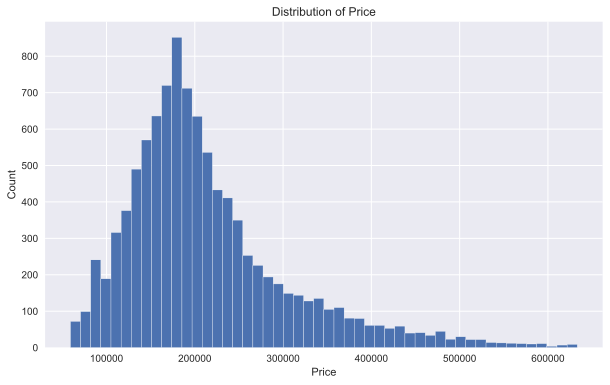

In [53]:
plt.figure(figsize = (10, 6))

df_train['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

Рассмотрим, как соотносятся медиана, средняя и мода. 

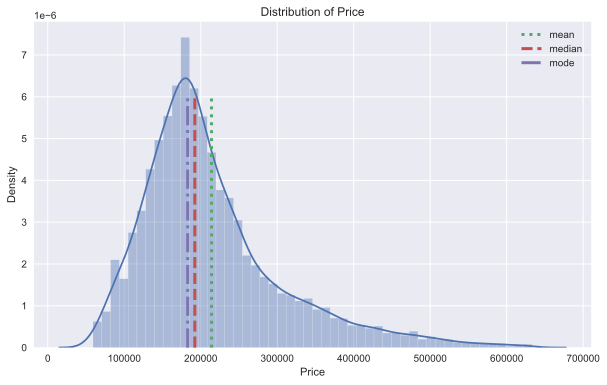

In [54]:
target_mean = round(df_train['Price'].mean(), 4)
target_median = round(df_train['Price'].median(), 4)
target_mode = round(df_train['Price'].mode()[0], 4)
    
plt.figure(figsize = (10, 6))

sns.distplot(df_train['Price'], bins=50)

y = np.linspace(0, 0.000006, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=3)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=3)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=3)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Так как mode < median < mean, то можно говорить о правосторонней ассиметрии распределения целевого признака.
Можно предположить достаточную емкость рынка дорогих квартир в элитных районах.

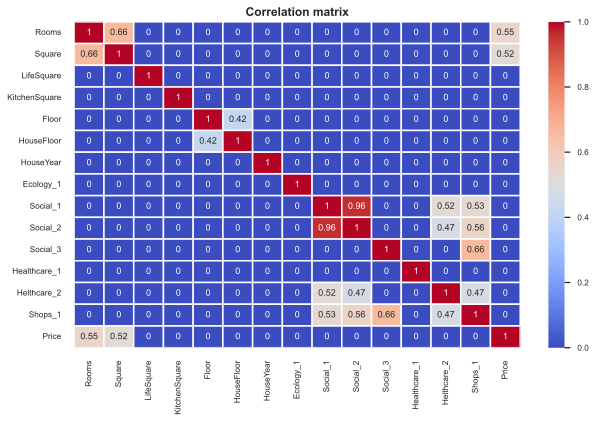

In [55]:
# и построим корреляционную матрицу, чтоб понять, что имеем

plt.figure(figsize = (10,6))
sns.set(font_scale=0.75)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=1.5, cmap='coolwarm')

plt.title('Correlation matrix', fontweight='bold', fontsize=12)
plt.show()

Признак Healthcare_1 линейно независим от других признаков. Можно удалить или заменить пропуски на медиану.

### Анализ факторных признаков

#### Номинативные переменные

In [56]:
#категории
df_cat_features = df_train.select_dtypes(include=['category'])
for i in df_cat_features:
    print('Количество уникальных значений признака ' + i)
    print(df_train[i].value_counts())
    print()

Количество уникальных значений признака Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64

Количество уникальных значений признака Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64

Количество уникальных значений признака Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64



In [57]:
# объекты
df_obj_features = df_train.select_dtypes(include=['object'])
for i in df_obj_features:
    print('Показатели признака ' + i)
    print(df_train['DistrictId'].describe().T)
    print()

Показатели признака Id
count     10000
unique      205
top          27
freq        851
Name: DistrictId, dtype: object

Показатели признака DistrictId
count     10000
unique      205
top          27
freq        851
Name: DistrictId, dtype: object



Выводы:

Территория поделена на 205 уникальных районов.  Нужно переводить либо в бинарные признаки, либо описывать категорию другим вещественным признаком, либо описывать эту категорию через целевой признак, это Target encoding, а можно признак описать через себя же, через value_counts() - тут каждое значение в нем подсчитывается - сколько объектов с таким значение встречаются. 

Признаки Ecology_2, Ecology_3, Shops_2 в дальнейшем можно будет заменить на бинарные: 0 и 1.

### Количественные переменные

In [58]:
# основные статистики
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


#### Проблемы : 
- есть пропуски: Healthcare_1 - 52% и LifeSquare - 78,87% от всей выборки

- mean - Social_3 - 8.039200, 50% - Social_3 - 2.000000, - разница в 4 раза; 

- min - Rooms - 0; 

- max - LifeSquare - 7480.592129; KitchenSquare - 2014.000000 - это больше, чем  max Squar, видимо есть ошибки регистрации.

- max HouseFloor 117 - самый высокий жилой дом в Москве в 101 этаж (One Tower) по данным "Российской газеты" средняя этажность по Москве составила до 25 на декабрь 2020. Учтем это при обработке фич.

- max Floor (420)> max HouseFloor (117)

- max HouseYear 2.005201e - есть ошибки регистрации.

### Обработка выбросов и Обработка пропусков

##### 1. HouseYear

In [59]:
# Все даты постройки, которые больше текущего года, заменяем на текущий год

df_train.loc[df_train['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

In [60]:
df_train['HouseYear'].sort_values(ascending=False)

8828    2022
9163    2022
7721    2020
9122    2020
7955    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int32

##### 2. HouseFloor, Floor

Эти признаки связанны с этажами, где стоят квартиры и с этажностью дома в целом, в котором эти квартиры находятся.

In [61]:
 # Смотрим на уникальные значения этих признаков.
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [62]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [63]:
# HouseFloor
# заменим на медиану, значения равные 0.
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

In [64]:
# домов выше 30-ти этажей немного. Заменим их этажность на 30.
df_train.loc[df_train['HouseFloor'] > 30, 'HouseFloor'] = 30

In [65]:
sum(df_train.loc[df_train['HouseFloor'] > 30, 'HouseFloor'].value_counts())

0

In [66]:
df_train['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30.], dtype=float32)

In [69]:
#посмотрим признак Floor
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

Есть значения этажа больше этажности самого дома. Исправим это.

In [70]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1616

это составляет 16 % от всех квартир на рынке. Можно заменить на значение 30. Помним статью.

In [72]:
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1616)

In [73]:
# с помощью random.randint, можно расставить в случайное место квартиру. 
#Взять объекты по этим индексам 'Floor', где этаж больше этажности,
#взять в этих объектах признак этажности 'HouseFloor' эту цифру, и случайно взять этаж от 1 до этажности (1, x).

df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor']\
                                         .apply(lambda x: random.randint(1, x))

In [74]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

##### 3. Rooms

In [75]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [76]:
df_train['Rooms'].median()

2.0

In [78]:
# создание вспомогательного признака
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
df_train.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0


In [79]:
# Обработка выбросов
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = 1
df_train.loc[df_train['Rooms'] >= 6, 'Rooms'] = df_train['Rooms'].median()

In [80]:
df_train['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### 4. Square, LifeSquare, KitchenSquare

Начнём с обработки  общей площади и площади кухни. Для этих признаков обработаем выбросы. Далее можно воспользоваться Square и KitchenSquare, чтобы заменить пропуски LifeSquare.

In [81]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Rooms_outlier       0
dtype: int64

In [82]:
df_train['KitchenSquare'].value_counts().unique()


array([2460, 1306, 1169, 1075, 1038,  843,  697,  609,  249,  233,   67,
         51,   39,   31,   22,   16,   14,   12,   11,    6,    4,    3,
          2,    1], dtype=int64)

In [83]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [84]:
condition = (df_train['KitchenSquare'].isna()) \
             | (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975))

df_train.loc[condition, 'KitchenSquare'] = df_train['KitchenSquare'].median()

df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [85]:
df_train['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1227
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

32.10518369674683 100.90624904632566


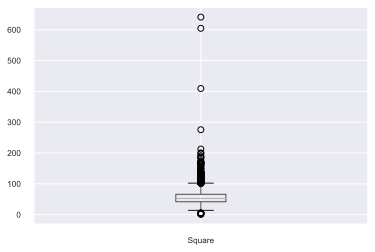

In [88]:
# Square 
df_train.boxplot(column='Square')
print(df_train['Square'].quantile(.025), df_train['Square'].quantile(.975))

Вывод:
Минимально адекватные значения - 32 Максимально адекватные значение - 210. Значения выше квантили 97,5% (100,9) существуют и в целом значение 100 м2 представляется адекватным.

In [89]:
#Пометим неадекватные значения площади и заменим их на адекватные.
df_train['Square_outlier'] = 0
df_train.loc[(df_train['Square'] < 32) & (df_train['Square'] > 210), 'Square_outlier'] = 1
df_train.loc[df_train['Square'] < 32, 'Square'] = 32
df_train.loc[df_train['Square'] > 210, 'Square'] =df_train['Square'].median()
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.875000,0,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.546875,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.718750,0,0
3,2352,1,1.0,40.409908,NaN,5.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.000000,0,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.093750,0,0


In [90]:
((df_train['LifeSquare'].isna()) | (df_train['LifeSquare'] > df_train['Square'])).sum()

2578

In [91]:
# Квартиры, в которых жилая площадь неопределена или больше общей, являются выбросами. Их необходимо обработать
condition = (df_train['LifeSquare'].isna()) | (df_train['LifeSquare'] > df_train['Square'])
# создание вспомогательного признака
df_train['LifeSquare_outlier'] = 0
df_train.loc[condition, 'LifeSquare_outlier'] = 1

In [94]:
# Найдем коэффициент жилой площади от общей
koef_median_ls = df_train['LifeSquare'].median() / df_train['Square'].median()
round(koef_median_ls, 3)

0.624

In [95]:
df_train.loc[condition, 'LifeSquare'] = df_train['Square'] * koef_median_ls
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier
0,11809,27,3.0,115.027313,71.805794,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.875000,0,0,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.546875,0,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.718750,0,0,0
3,2352,1,1.0,40.409908,25.225883,5.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.000000,0,0,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,B,343995.093750,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,10311,6,NaN,1,9,B,119367.453125,0,0,0
9996,16265,27,2.0,64.307686,37.038422,9.0,13,13.0,1977,0.072158,...,629,1,NaN,0,0,A,199715.156250,0,0,0
9997,2795,178,1.0,32.000000,16.555363,5.0,3,5.0,1958,0.460556,...,4386,14,NaN,1,5,B,165953.906250,0,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,8004,3,125.0,3,5,B,171842.406250,0,0,0


In [96]:
df_train[['LifeSquare']].isna().sum()

LifeSquare    0
dtype: int64

In [97]:
df_train['LifeSquare_nan'] = df_train['LifeSquare'].isna() * 1

condition = (df_train['LifeSquare'].isna()) \
             & (~df_train['Square'].isna()) \
             & (~df_train['KitchenSquare'].isna())
        
df_train.loc[condition, 'LifeSquare'] = df_train.loc[condition, 'Square'] \
                                            - df_train.loc[condition, 'KitchenSquare'] - 5

##### 5. Healthcare_1

In [98]:
df_train.drop('Healthcare_1', axis=1, inplace=True) 

In [99]:
df_train.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
Square_outlier        0
LifeSquare_outlier    0
LifeSquare_nan        0
dtype: int64

### Построение новых признаков

6. 'Ecology_2', 'Ecology_3' и 'Shops_2'

In [100]:
#категории 'Ecology_2', 'Ecology_3' и 'Shops_2' - всего лишь два уникальных значения, которые легко переводятиься в 0 и 1.
binary_to_numbers = {'A': 0, 'B': 1}
f_list = ['Ecology_2', 'Ecology_3', 'Shops_2']

for i in f_list:
    df_train[i] = df_train[i].replace(binary_to_numbers)

7. DistrictSize

DistrictId района заменяем с помощью .value_counts() на подсчитанные квартиры - сколько находиться в каждом районе. Готовим небольшой датафрейм, переменуем колонки из индекса на DistrictId, а потом количество объектов, сколько было во всех этих районах мы переменуем на DistrictSize.

In [101]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [102]:
#Присоединяем обучаещему датасету эту вспомогательную таблицу.
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027313,71.805794,10.0,4,10.0,2014,0.075424,...,0,0,0,1,305018.875000,0,0,1,0,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,1,0,1,177734.546875,0,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,3,1,1,282078.718750,0,0,0,0,652
3,2352,1,1.0,40.409908,25.225883,5.0,10,22.0,1977,0.007122,...,0,0,1,1,168106.000000,0,0,1,0,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,2,0,6,1,343995.093750,0,0,0,0,89


Вот тут показано что первый район 27 он описывается цифрой 851, её видим в новой колонке DistrictSize. Далее можно убрать признак DistrictId из обучения и обучаться только на DistrictSize.

Вот таким образом перевели из категории во что-то вещественное через описание признака через самого себя.

Сделаем ещё один признак - бинарный - большой или небольшой район. Условно будем считать, что если в районе более ста квартир, то это большой район, если меньше, то значит это будет маленький район.

In [103]:
(df_train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [104]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

8. MedPriceByDistrict

Полезными признаками считаются Target encoding, т.е. целевая переменная кодируется через другие признаки. Здесь предсказыаем стоимость квартиры и логично что стоимость квартиры варьируется как зависимость, например, от района. Сделаем группировку от района, посчитаем медианую целевую переменную. И так же её переименуем, чтобы не было наслоения одинаковых наименований колонок.

In [105]:
#Медианная цена за квадратный метр жилья по району
med_price_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPrice_District'})

med_price_by_district.head(2)

,DistrictId,MedPrice_District
0,0,165963.0625
1,1,183663.4375


In [106]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId'], how='left')
df_train.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPrice_District
0,11809,27,3.0,115.027313,71.805794,10.0,4,10.0,2014,0.075424,...,0,1,305018.875000,0,0,1,0,851,1,146171.4375
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,1,177734.546875,0,0,0,0,78,0,183678.1250



8. M2Price

In [107]:
#Цена за квадратный метр жилья
df_train['M2Price'] = df_train['Price'] / df_train['Square']

In [108]:
round(df_train['M2Price'].mean(), 2)

3887.5

#### Классы подготовки данных и генерации фичей

In [109]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        
        """Константы для обработки выбросов на основе анализа данных"""
        self.Square_min = 32
        self.Square_max = 210
               
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 30
        
        self.KitchenSquare_min = 5
        self.KitchenSquare_max = 13   
                    
        """Параметры класса"""
        self.medians = None
        self.koef_median_ls = None
        self.current_year = datetime.now().year
        self.disctrict_healthcare = None
                
    def fit(self, X):
        
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.districts_healthcare = X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        self.koef_median_ls = self.medians['LifeSquare'] / self.medians['Square']
                               
    def transform(self, X): #y=None
        """Трансформация данных"""
        # Обработка пропусков и # Обработка выбросов
        
        # площадь
        X.loc[(X['Square'] > self.Square_max), 'Square'] = self.Square_max
        X.loc[(X['Square'] < self.Square_min), 'Square'] = self.Square_min
        # площадь кухни
        X.loc[X['KitchenSquare'] < self.KitchenSquare_min, 'KitchenSquare'] = self.KitchenSquare_min
        X.loc[(X['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        # количество комнат
        X.loc[(X['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        X.loc[(X['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        # количество этажей
        X.loc[(X['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        X.loc[(X['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # LifeSquare
        
        # Квартиры, в которых жилая площадь неопределена или больше общей, являются выбросами. Их необходимо обработать
        condition = (X['LifeSquare'].isna()) | (X['LifeSquare'] > X['Square'])
        # создание вспомогательного признака и обработка выбросов 
        X['LifeSquare_outlier'] = 0
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = X['Square'] * self.koef_median_ls      
        
        # Floor

        # создание вспомогательного признака
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        # Обработка выбросов
        # с помощью random.randint, можно расставить в случайное место квартиру. 
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min
        if (self.HouseFloor_min == x)  else np.random.randint(self.HouseFloor_min, x))
        
        
        # HouseYear
                       
        X.loc[X['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

        X.fillna(self.medians, inplace=True)
       
        # Healthcare_1
                
        #if 'Healthcare_1' in df_train.columns:
            #df_train.drop('Healthcare_1', axis=1, inplace=True)   
              
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare)
        X['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        
        X.fillna(self.medians, inplace=True)         
                                
        return X
    
    

In [110]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_district = None
        
        
        self.M2Price = None
        self.M2PriceByDistrict = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        #добавление признака DistrictSize
        self.district_size = df_train['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
                                   
            df['M2Price'] = df['Price'] / df['Square']
            self.med_m2_price_district = df.groupby(['DistrictId'], as_index=False).agg({'M2Price':'median'})\
                             .rename(columns={'M2Price':'MedM2Price_District'})
            self.med_m2_price_district_median = self.med_m2_price_district['MedM2Price_District'].median()
         
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
                
        #добавление признака DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # Target encoding
                  
        if self.med_m2_price_district is not None:
            X = X.merge(self.med_m2_price_district, on=['DistrictId'], how='left')
            X['MedM2Price_District'].fillna(self.med_m2_price_district_median, inplace=True)
    #Убираем идентификаторы
        X.drop(['Id'], axis=1, inplace=True)
        #X['DistrictId'] = X['DistrictId'].astype(str)    
        return X
    
    def yearhouse_cat (self, X):
        # yearhouse categories
        X['yearhouse_cat'] = 3
        X[df_train['HouseYear'] <= 2000, 'yearhouse_cat'] = 2
        X.loc[df_train['HouseYear'] >= 1990, 'yearhouse_cat'] = 1
        return X
    def yearhouse_cat (self, X):   
        # first and last floors categories
        X['floor_cat'] = 1
        X.loc[(df_train['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'floor_cat'] = 0
        return X
        
        

In [111]:
# выбор признаков для обучения
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
                

new_feature_names = ['MedPrice_District', 'DistrictSize' ]

target_name = 'Price'

In [112]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
X = df_train.drop(columns=target_name)
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [113]:
X_train.shape, X_valid.shape, df_test.shape

((6700, 19), (3300, 19), (5000, 19))

In [114]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 20), (3300, 20), (5000, 20))

In [115]:
new_features = FeatureGenetator()
new_features.fit(X_train, y_train)

X_train = new_features.transform(X_train)
X_valid = new_features.transform(X_valid)
df_test = new_features.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 23), (3300, 23), (5000, 23))

In [116]:
X_train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'LifeSquare_outlier', 'DistrictSize',
       'new_district', 'IsDistrictLarge', 'MedM2Price_District'],
      dtype='object')

In [117]:
X_valid.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'LifeSquare_outlier', 'DistrictSize',
       'new_district', 'IsDistrictLarge', 'MedM2Price_District'],
      dtype='object')

In [118]:
df_test.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'LifeSquare_outlier', 'DistrictSize',
       'new_district', 'IsDistrictLarge', 'MedM2Price_District'],
      dtype='object')

In [119]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.907600,0.809687,1.000000,1.000000,2.000000,2.000000,5.000000
Square,5000.0,56.560021,18.851480,32.000000,41.906231,52.921340,66.285129,210.000000
LifeSquare,5000.0,35.261287,14.834279,0.333490,24.126929,33.045328,43.730805,136.921090
KitchenSquare,5000.0,6.988600,2.267487,5.000000,5.000000,6.000000,9.000000,13.000000
Floor,5000.0,7.295800,5.134547,1.000000,3.000000,6.000000,10.000000,28.000000
HouseFloor,5000.0,12.574600,6.498837,1.000000,9.000000,12.000000,17.000000,30.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Ecology_2,5000.0,0.990400,0.097518,0.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
# считаем пропуски в данных
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

### Стандартизация признаков

In [121]:
feature_names_for_stand = X_train.select_dtypes(include=['float64', 'int32']).columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1',
 'IsDistrictLarge',
 'MedM2Price_District']

In [122]:
scaler =  StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])
stand_features_test = scaler.transform(df_test[feature_names_for_stand])

In [123]:
X_train[feature_names_for_stand] = stand_features_train
X_valid[feature_names_for_stand] = stand_features_valid
df_test[feature_names_for_stand] = stand_features_test

In [124]:
X_train.shape, X_valid.shape, df_test.shape

((6700, 23), (3300, 23), (5000, 23))

### Построение модели

In [125]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Оценка качества модели и построение графиков Train and Test sample prediction"""
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,8))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Тренировочные значения')
    plt.title('Тренировочные предсказания')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Валидационные значения')
    plt.title('Валидационные предсказания')

    plt.show()

In [126]:
#lr
#lr_model = LinearRegression()
#lr_model.fit(X_train, y_train)
             
#y_train_preds = lr_model.predict(X_train)
#y_test_preds = lr_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#Train R2:	0.675
#Test R2:	0.641

In [129]:
#dt_model = DecisionTreeRegressor(criterion='mse',
                                # random_state=42,
                                 #max_depth=400,
                                #min_samples_leaf=1,
                                # )

#dt_model.fit(X_train, y_train)
 
#y_train_preds = rf_model.predict(X_train)
#y_test_preds = rf_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#Train R2:	0.862
#Test R2:	0.719

Train R2:	0.862
Test R2:	0.72


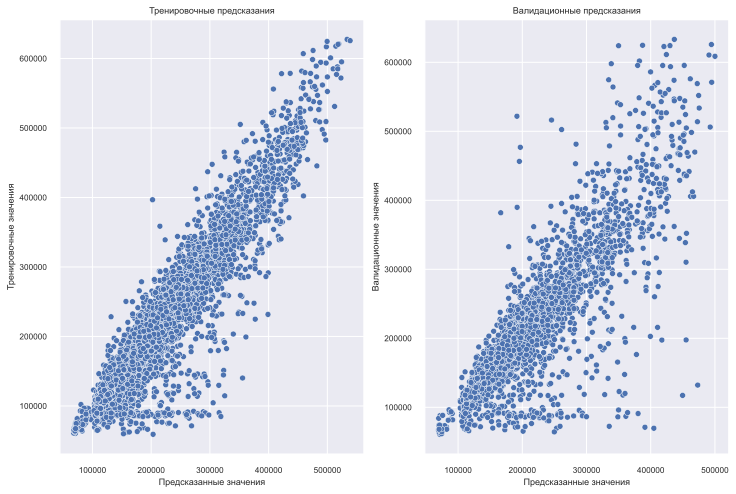

In [128]:
rf_model = RandomForestRegressor(criterion='mse',
                                 random_state=21,
                                 max_depth=9,
                                 max_features=9,
                                 n_estimators=300)

rf_model.fit(X_train, y_train)

    
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

Отметим, что результаты dt_model = DecisionTreeRegressor и rf_model = RandomForestRegressor одинаковые

In [134]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.76109845, 0.72693532, 0.75133023])

In [135]:
round(cv_score.mean(), 3)

0.746

Делая кросс-валидацию модели на обучающей выборке, по методу R2, и кросс-валидацию на три хода, получаем три цифры, и их среднее 0.747. Эта цифра отличается от двух предыдущих.(0.862 и 0.72). В идеале, когда всё три цифры - метрика на обучении,на тесте, и на кросс-валидации стремяться к одному значению, это значит, что переобучение минимальное.

In [136]:
#Важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.289570
22,MedM2Price_District,0.220150
1,Rooms,0.114060
3,LifeSquare,0.092095
19,DistrictSize,0.077843
11,Social_1,0.034058
12,Social_2,0.032766
4,KitchenSquare,0.023065
7,HouseYear,0.021282
13,Social_3,0.017749


<AxesSubplot:>

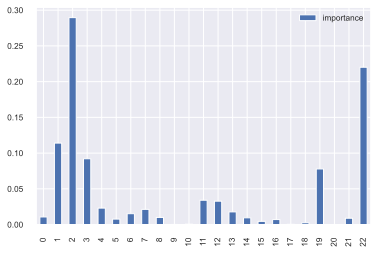

In [137]:
feature_importances.plot.bar()

###  Итоговое предсказание

Выполнить для тестового датасета те же этапы обработки и постронияния признаков Не потерять и не перемешать индексы от примеров при построении прогнозов Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [138]:
df_test.shape

(5000, 23)

In [139]:
df_test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_outlier,DistrictSize,new_district,IsDistrictLarge,MedM2Price_District
0,44,-1.092045,-1.013131,-1.057725,-0.880249,5,-0.543204,1970,-0.687454,1,...,0,0.019578,1,1,1,0,104.0,0,0.985479,0.539552
1,62,-1.092045,-0.715351,-0.570344,1.324487,7,0.699412,2017,-0.386677,1,...,1,-0.162878,0,0,0,1,247.0,0,0.985479,-1.324296
2,27,0.143050,0.179622,0.129960,0.883540,19,1.010066,1977,0.775549,1,...,0,-0.162878,0,1,1,1,851.0,0,0.985479,-1.147779
3,23,1.378144,-0.338153,-0.076274,-0.439302,2,-1.630494,1965,-0.871493,1,...,0,-0.162878,0,0,1,0,565.0,0,0.985479,-1.648021
4,74,-1.092045,-0.117122,-0.102238,-0.880249,8,0.699412,1977,1.594177,1,...,4,-0.042135,0,6,1,1,114.0,0,0.985479,-0.511346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,0.143050,-0.679297,-0.311953,-0.880249,2,-1.164513,1962,-0.407521,1,...,4,-0.162878,1,2,1,0,89.0,0,-1.014735,0.220974
4996,38,1.378144,1.985121,1.542739,1.324487,21,2.252683,2018,-0.481868,1,...,2,-0.672682,0,7,1,1,36.0,0,-1.014735,0.722443
4997,101,-1.092045,-1.181417,-1.063755,-0.880249,2,-1.164513,1966,-0.665997,1,...,1,-0.008595,2,5,1,0,97.0,0,-1.014735,0.214610
4998,10,-1.092045,-0.918858,-0.932914,0.883540,8,0.233431,1970,-0.245767,1,...,5,-0.162878,0,11,1,0,56.0,0,-1.014735,0.585864


In [140]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [141]:
predictions = rf_model.predict(df_test)
predictions

array([165908.67112318, 123589.00506841, 151830.34480423, ...,
       148927.83232687, 184833.87325808, 266089.67489922])

In [142]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165908.671123
1,5925,123589.005068
2,960,151830.344804
3,3848,131228.815273
4,746,178621.070220


In [143]:
submit.shape

(5000, 2)

In [144]:
submit.to_csv('LZolotuhina_final.csv', index=False)